In [215]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns



In [216]:
# Initialize Lattice
L = 3
dx = 0.1
x = np.arange(0, L, dx) # range [0, 5]
y = -x # range [-5, 0] (depth)
N = len(x)
lattice = np.zeros((N, N))


# Assign Solid Pixels Randomly represented by a 1 in matrix

# Number of solid pixels
perm_percent = 0.9
num_solid = int(perm_percent*N*N)

# Location of solid pixels
solid_coords = np.random.randint(low=0, high=N, size=(num_solid,2))
lattice[solid_coords[:, 0], solid_coords[:, 1]] = 1 


(900, 2)


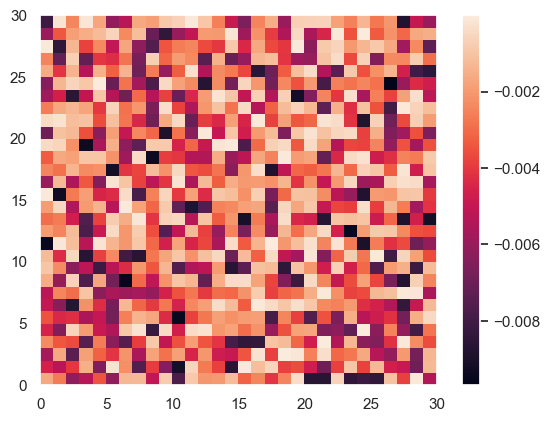

In [217]:

# Assign velocity vectors at each pixel
angle = np.random.uniform(np.pi, 2 * np.pi, size=(N* N , 2)) #generate angle in lower half plane (from pi to 2 pi)
direction = np.array([np.cos(angle[:,0]), np.sin(angle[:,1])]) # decompose into x and y components
direction= np.transpose(direction)
print(direction.shape)
magnitude = np.random.uniform(1, 10, size=(N*N)) * 10**-3 # randomly choose magnitude between 1 and 10 mm/s

#scale unit vectors
x_comp = magnitude*direction[:, 0]
x_comp=x_comp.reshape(N,N)

y_comp = magnitude*direction[:, 1]
y_comp=y_comp.reshape(N,N)
magnitude=magnitude.reshape(N,N)

plt.figure()
plt.pcolor(y_comp)
plt.colorbar()







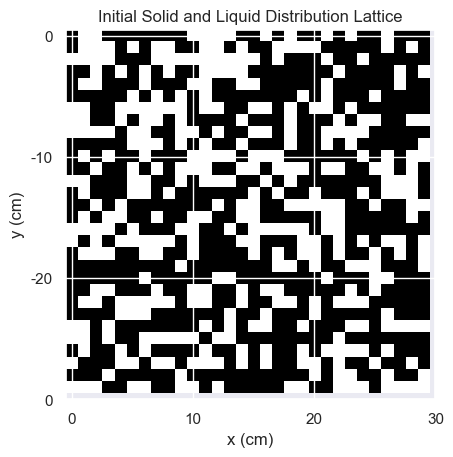

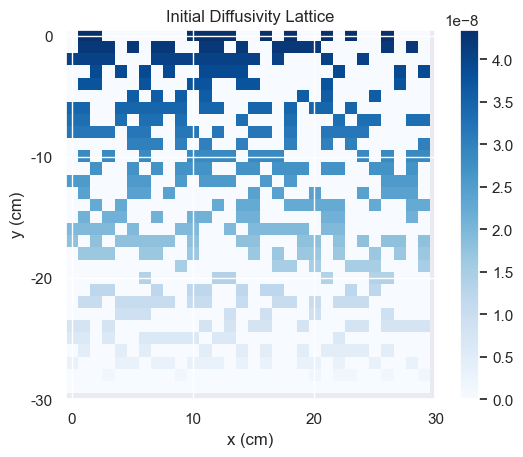

In [218]:

# Constants
kappa_d = 1.5 * 10 ** -7 # m^2 s^-1 water thermal diffusivity

# Calculate D0 at Each Pixel
D_0_vec = x * kappa_d * dx
D_0_vec = np.flip(D_0_vec)

D_0 = np.repeat(D_0_vec[np.newaxis,...], N, axis=0)
D_0 = D_0.transpose()
D_0[lattice > 0] = 0

# Plot Initial Lattices
plt.figure()
plt.imshow(lattice, cmap="Greys", interpolation='none')
plt.title("Initial Solid and Liquid Distribution Lattice")
plt.xticks([0, 10, 20, 30])
plt.xlabel("x (cm)")
plt.yticks([0,  10, 20, 30], [0, -10, -20, -00])
plt.ylabel("y (cm)")


plt.figure()
plt.imshow(lattice, cmap="Greys", interpolation='none')

plt.imshow(D_0,cmap="Blues" ,interpolation='none')
plt.title("Initial Diffusivity Lattice")
plt.xticks([0, 10, 20, 30])
plt.xlabel("x (cm)")
plt.yticks([0,  10, 20, 30], [0, -10, -20, -30])
plt.ylabel("y (cm)")
plt.colorbar()





In [ ]:
# Random Walk

i = 0
j = int(N/2)
position = np.array([i, j]) # start walk at center top of snow


left = lattice[i,j-1]
right = lattice[i, j+1]
down = lattice[i+1, j]
states = np.array([left, right ,down])
keep_going = True

# check if solid
if(states==[1, 1, 1]):
    keep_going=False

def computeProbability(D_i, D_j, v_j, i, j):
    #D_i is diffusivity at current location
    #D_j is diffusivity at new location
    #v_ij is velocity at pixel j (need to calculate direction of flow at pixel j in direction of i)
    #i is position of pixel i
    #j is position of pixel j

    

    

    return 

# left probability

# right probability

# down probability





False